In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline

In [2]:
"""
    Define market with linear demand.
    Market is characterized by demand function, which is characterized by A and b
    Right now we assume a simplt to player market.
"""
n = 2
A = np.matrix('-3 -2; -1, -3')
B = np.matrix('6;6')

In [22]:
"""
    Describes the evolition of the system.
    Here barx1 and barx2 evolve by only looking at indiviudal profits
    dx1 and dx2 evolve to maximize difference between sidepayment and losses.
    alpha and beta evolve to with the assumption that deltax2 is at opitmum,
        which allows for a straightforward expression for (d dx2/d beta)
    Vector order [barx1, barx2, dx2, beta, dx1, alpha]
"""
def dynamics( x, t ):
    x = np.matrix(x).T
    J = np.matrix('-6 -2 0 0 0 0; -1 -6 0 0 0 0')
    x_dot = J*x + B
    barx1 = x[0]
    barx2 = x[1]
    dx2 = x[2]
    beta = x[3]
    dx1 = x[4]
    alpha = x[5]
    x1 = barx1 + dx1
    x2 = barx2 + dx2

    dx1_dot = alpha*A[1,0]*x2 + (2*A[0,0]*x1 + A[0,1]*x2 + B[0] )
    dx1_opt = ( alpha*A[1,0]*x2 + (2*A[0,0]*barx1 + A[0,1]*x2 + B[0]) )/(-2*A[0,0])
    alpha_dot = A[1,0]*A[1,0]*x2/(-2*A[0,0]) - 1*(x2*dx1_opt*A[1,0]) + ((A[1,0]*x2)**2)*(1-alpha)/(-2*A[0,0]) 
    
    dx2_dot = beta*A[0,1]*x1 + (2*A[1,1]*(x2) + A[1,0]*x1 + B[1] )
    dx2_opt = ( x[3]*A[0,1]*x[0] + (2*A[1,1]*x[1] + A[1,0]*x[0] + B[1]) )/(-2*A[1,1])
    #dx2_opt = 1
    beta_dot = A[0,1]*A[0,1]*x1/(-2*A[1,1]) - 1*(x1*dx2_opt*A[0,1]) + ((A[0,1]*x1)**2)*(1-beta)/(-2*A[1,1])
    x_dot = x_dot.reshape(2,).tolist()[0]
    
    #multiplicative constant
    c = 1.0
    x_dot.append(c*dx2_dot[0,0])
    x_dot.append(c*beta_dot[0,0])
    x_dot.append(c*dx1_dot[0,0])
    x_dot.append(c*alpha_dot[0,0])
    
    #check limits (though I don't think these should be necessary)
    #check that beta is between 0 and 1
    if x[3] >= 1 and x_dot[3] > 0:
        x_dot[3] = 0
    if x[3] <= 0 and x_dot[3] < 0:
        x_dot[3] = 0
        
    if x[5] >= 1 and x_dot[5] > 0:
        x_dot[5] = 0
    if x[5] <= 0 and x_dot[5] < 0:
        x_dot[5] = 0
    #make sure delta is not greater than x2
    #perhaps here we need to think of coeficients
    if (x[1] + x[2]) <=0 and ( x_dot[2] + x_dot[1] ) < 0:
        x_dot[2] = 0
    #print x_dot, x
    return x_dot

In [32]:
x0 = [0,0,0,0,0,0]
#x0 = [12.0/17,15.0/17,0,0,0,0]

t = np.linspace(0.0, 30, 10000)
x = odeint(dynamics, x0, t)

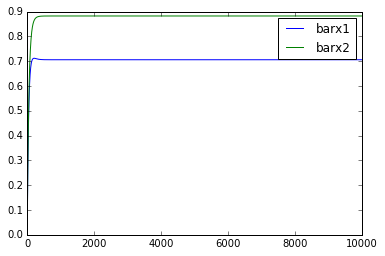

In [33]:
df = pd.DataFrame(x)
df.columns = ['barx1', 'barx2', 'dx2', 'beta', 'dx1', 'alpha']
df[['barx1', 'barx2']].plot()

In [34]:
df['x2'] = df['barx2'] + df['dx2']
df['x1'] = df['barx1'] + df['dx1']
df['p1sur'] = (df['x1']*A[0,1]*df['dx2'])
df['p2sur'] = (df['x2']*A[1,0]*df['dx1'])
df['Pi1NC']  = df['x1']*(A[0,0]*df['x1'] + A[0,1]*df['barx2'] + B[0,0])
df['Pi2NC']  = df['x2']*(A[1,1]*df['x2'] + A[1,0]*df['barx1'] + B[1,0])

In [35]:
df['V1'] = df['Pi1NC'] + (1 - df['beta'])*df['p1sur'] + df['alpha']*df['p2sur']
df['V2'] = df['Pi2NC'] + (1 - df['alpha'])*df['p2sur'] + df['beta']*(df['p1sur'])
df['sw'] = df['V1'] + df['V2']

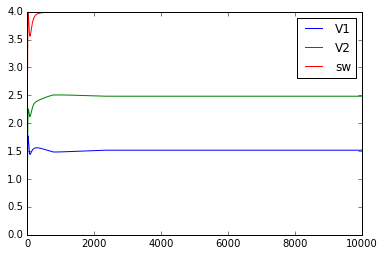

In [36]:
df[['V1', 'V2', 'sw']].plot()

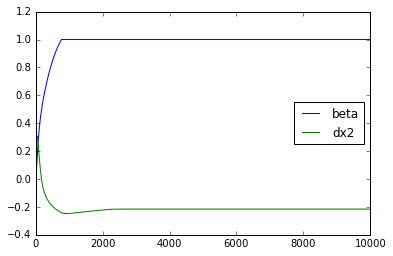

In [37]:
df[['beta', 'dx2']].plot()

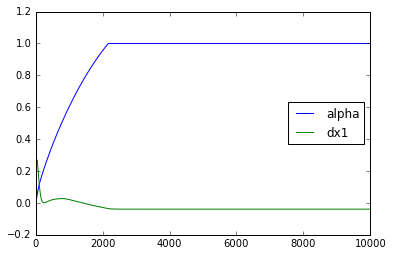

In [38]:
df[['alpha', 'dx1']].plot()

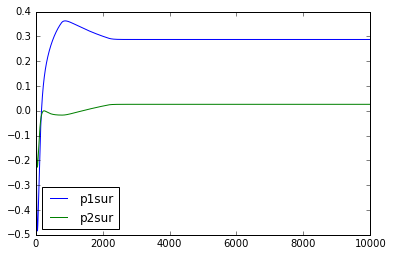

In [39]:
df[['p1sur', 'p2sur']].plot()

In [40]:
df[['V1', 'V2', 'sw', 'alpha', 'beta', 'dx2', 'x2', 'dx1', 'x1']].tail(4)

,V1,V2,sw,alpha,beta,dx2,x2,dx1,x1
9996,1.51634,2.48366,4,1,1,-0.215686,0.666667,-0.039216,0.666667
9997,1.51634,2.48366,4,1,1,-0.215686,0.666667,-0.039216,0.666667
9998,1.51634,2.48366,4,1,1,-0.215686,0.666667,-0.039216,0.666667
9999,1.51634,2.48366,4,1,1,-0.215686,0.666667,-0.039216,0.666667
